In [1]:
import os
import zipfile
import gdown


os.makedirs("processed_celeba_small")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "processed_celeba_small/data.zip"
gdown.download(url, output, quiet=True)


with zipfile.ZipFile("processed_celeba_small/data.zip", "r") as zipobj:
    zipobj.extractall("processed_celeba_small")

In [2]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import unittest as tests
import torch
from torchvision import datasets
from torchvision import transforms

%matplotlib inline

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
  
    # Define image augmentation methods
    data_transforms = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor()])
    
    # Load the dataset with ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
    
    # Define the dataloader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return data_loader


In [5]:
# Define function hyperparameters
batch_size = 28
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


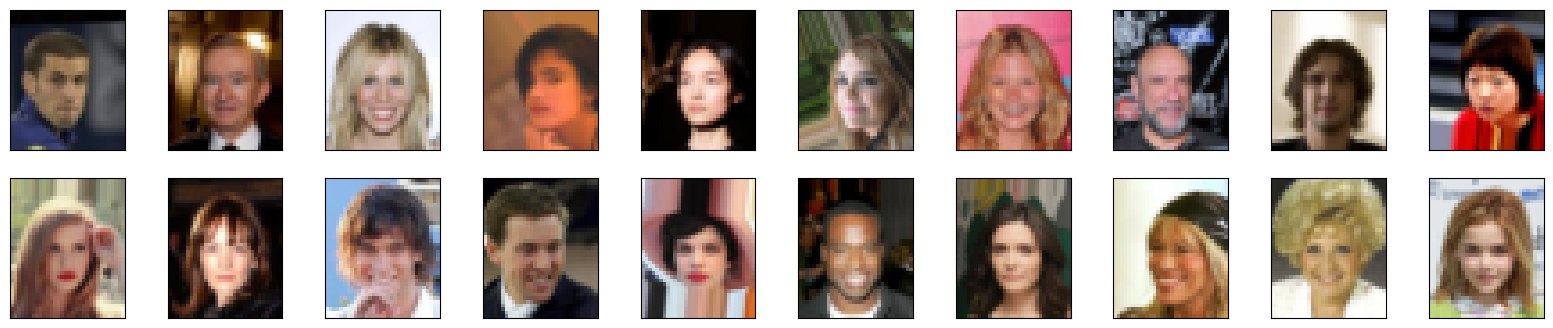

In [29]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = next(dataiter) # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):


    max_scale = max(feature_range)
    min_scale = min(feature_range)
    
    # Scale to feature range
    x = x * (max_scale-min_scale) + min_scale
    
    return x


In [8]:

# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.6941)


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):

        super(Discriminator, self).__init__()

        # define all convolutional layers
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        # define last classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)
        
        # define activation function
        self.leakyrelu = nn.LeakyReLU()
        
        # define dropout layer
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):

        ## define feedforward behavior
        # all convolutional layers
        x = self.leakyrelu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.dropout(x)
        x = self.leakyrelu(self.conv4(x))
        x = self.dropout(x)
        
        # last classification layer
        out = self.conv5(x).view(-1, 1)
        
        return out


"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):

        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        ## Define input fully connected layer
        self.fcin = nn.Linear(z_size, 4*4*conv_dim*4)
        
        ## Define transpose convolutional layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4, batch_norm=True)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4, batch_norm=True)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        ## Define activation function
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):

        ## input fully connected layer
        x = self.fcin(x)
        
        ## reshape the tensor for transpose concolutional layer
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        ## convolutional layers
        x = self.relu(self.t_conv1(x))
        x = self.relu(self.t_conv2(x))
        
        ## last convolutional layer with tanh act function
        out = self.tanh(self.t_conv3(x))
        
        return out


"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

In [14]:
from torch.nn import init

def weights_init_normal(m):

    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        ## Initialize conv and linear layer
        init.normal_(m.weight.data, 0.0, 0.02)
    

In [15]:

def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 64
z_size = 256

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fcin): Linear(in_features=256, out_fea

In [17]:

import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [18]:
def real_loss(D_out):

    loss = torch.mean(D_out-1)**2
    return loss

def fake_loss(D_out):

    loss = torch.mean(D_out**2)
    return loss

In [19]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.3
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [20]:
def train(D, G, n_epochs, print_every=50):

    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            # ==================================================
            # 1. Train the discriminator on real and fake images
            # ==================================================
            
            d_optimizer.zero_grad()
            
            ## Compute real loss on discriminator
            
            # move real images to GPU if available
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # pass real images to descriminator
            D_real = D(real_images)
            
            # compute real loss of descriminator
            d_real_loss = real_loss(D_real)
            
            
            ## Compute fake loss on discriminator
            
            # Compute latent vector z
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            # generate fake images with generator
            fake_images = G(z)
            
            # pass fake images to descriminator
            D_fake = D(fake_images)
            
            # compute fake loss of descrimintor
            d_fake_loss = fake_loss(D_fake)
            
            
            ## Compute total descriminator loss
            d_loss = d_real_loss + d_fake_loss
            
            ## Perform backprop to the descriminator
            d_loss.backward()
            d_optimizer.step()

            # ===============================================
            # 2. Train the generator with an adversarial loss
            # ===============================================
            
            g_optimizer.zero_grad()
            
            # generate latent vector z
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            # generate fake images from latent vector z
            fake_images = G(z)
            
            # compute generator loss
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # perform backprop on generator
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [21]:
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):

    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):

    with active_session(delay, interval): yield from iterable

In [30]:
# set number of epochs 
n_epochs = 10

# call training function
with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 0.0013 | g_loss: 0.9800
Epoch [    1/   10] | d_loss: 0.0001 | g_loss: 1.0040
Epoch [    1/   10] | d_loss: 0.0032 | g_loss: 1.0225
Epoch [    1/   10] | d_loss: 0.0007 | g_loss: 1.0108
Epoch [    1/   10] | d_loss: 0.0003 | g_loss: 0.9973
Epoch [    1/   10] | d_loss: 0.0001 | g_loss: 0.9947
Epoch [    1/   10] | d_loss: 0.0001 | g_loss: 1.0011
Epoch [    1/   10] | d_loss: 0.0003 | g_loss: 0.9882
Epoch [    1/   10] | d_loss: 0.0005 | g_loss: 0.9875
Epoch [    1/   10] | d_loss: 0.0001 | g_loss: 1.0065
Epoch [    1/   10] | d_loss: 0.0000 | g_loss: 1.0067
Epoch [    1/   10] | d_loss: 0.0002 | g_loss: 1.0105
Epoch [    1/   10] | d_loss: 0.0007 | g_loss: 0.9891
Epoch [    1/   10] | d_loss: 0.0001 | g_loss: 0.9971
Epoch [    1/   10] | d_loss: 0.0002 | g_loss: 0.9895
Epoch [    1/   10] | d_loss: 0.0005 | g_loss: 0.9945
Epoch [    1/   10] | d_loss: 0.0004 | g_loss: 1.0067
Epoch [    1/   10] | d_loss: 0.0003 | g_loss: 1.0071
Epoch [    1/   10] | d_loss

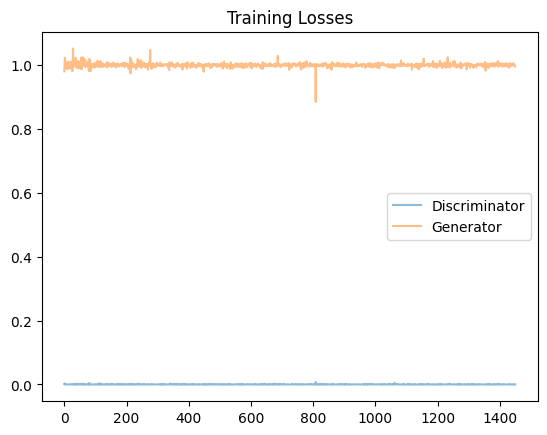

In [31]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [32]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [33]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

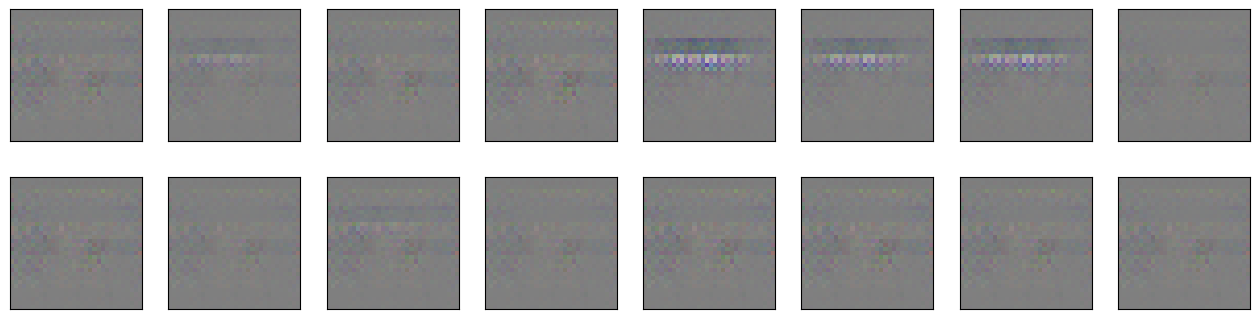

In [34]:
_ = view_samples(-1, samples)